In [1]:
import sys 
sys.path.insert(0,"/gpfswork/rech/omr/uen17sn/NewSpinUp/lib/sklearnGPmodel")
import sklearnGPmodel as skgp

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gpytorch
from torch.nn import Parameter
import math

## **Get Data**

In [2]:
simu_nb = 204
time_axis = "yearly"

In [3]:
df1 = pd.read_csv(f"/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/{time_axis}/dataFrame/simu{203}")
df2 = pd.read_csv(f"/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/{time_axis}/dataFrame/simu{204}")
df3 = pd.read_csv(f"/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/{time_axis}/dataFrame/simu{212}")

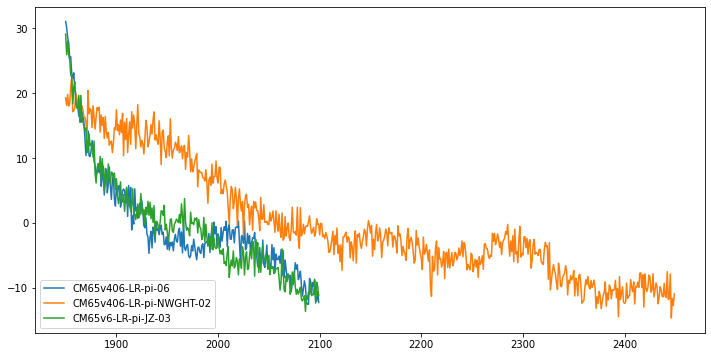

In [4]:
fig = plt.figure(figsize=(12,6))
plt.plot(np.arange(1850,2100),df1["MSFT-1"],label = "CM65v406-LR-pi-06" )
plt.plot(np.arange(1850,2450),df2["MSFT-1"],label = "CM65v406-LR-pi-NWGHT-02" )
plt.plot(np.arange(1850,2100),df3["MSFT-1"],label = "CM65v6-LR-pi-JZ-03" )
plt.legend(loc=3)

In [5]:
df = pd.read_csv(f"/gpfswork/rech/omr/uen17sn/NewSpinUp/datasets/{time_axis}/dataFrame/simu{simu_nb}")
df.shape

(600, 18)

In [6]:
df.head()

,Unnamed: 0,MSFT-1,MSFT-2,MSFT-3,MSFT-4,MSFT-5,MSFT-6,MSFT-7,MSFT-8,MSFT-9,MSFT-10,MSFT-11,MSFT-12,MSFT-13,MSFT-14,MSFT-15,MSFT-16,MSFT-17
0,0,19.270443,2.142370,0.393435,0.900593,1.674075,0.656456,0.697247,0.299805,-2.402743,0.250962,-0.692004,-0.592743,-1.282935,2.066055,-1.230658,1.050119,0.626496
1,1,18.126086,-0.317462,1.876019,-2.290273,1.152702,-2.839545,0.043029,0.230378,-2.881111,0.739010,-0.662857,1.469690,-2.224213,1.880381,-1.237545,-0.457881,0.177222
2,2,19.799096,4.408964,2.863528,0.156425,1.995186,1.479123,-0.352089,2.045279,-3.024101,1.110103,-1.412786,1.121846,-0.853135,1.741023,0.928641,-1.775934,1.091334
3,3,18.021828,2.703452,0.278213,-0.685550,0.850088,2.022986,0.541819,0.463398,-2.676218,2.447300,-1.699289,-0.256894,-0.720332,1.380011,-0.863466,-0.841869,0.206651
4,4,18.324972,-1.704952,2.662613,-0.800777,1.806584,0.453126,1.556290,-0.343425,-1.930756,1.832212,-2.703416,0.217363,-0.265366,0.658164,-1.171646,-0.402770,-0.508395


In [7]:
date_range = np.arange(len(df))
df["date"] = date_range

data = df[["date", "MSFT-1"]].set_index("date")

### 1.2 - Split datas

In [8]:
split_index = int(0.50 * len(df))
max_index   = len(data)

In [9]:
train_data = data[:split_index]
test_data  = data[split_index:max_index+10]

In [28]:
X_train = torch.from_numpy((train_data.index).to_numpy().reshape(-1, 1))
X_train = X_train.to(dtype=torch.float64)

#X_train = torch.tensor(train_data.index.values.reshape(-1, 1), dtype=torch.double)

y_train = torch.from_numpy(train_data["MSFT-1"].to_numpy())
y_train = y_train.to(dtype=torch.float64)

X_test = torch.arange(len(data)+10).reshape(-1, 1)
X_test = X_test.to(dtype=torch.float64)

xdatatest =  torch.from_numpy((test_data.index).to_numpy().reshape(-1, 1))
y_test = torch.from_numpy(test_data["MSFT-1"].to_numpy())

## **Create Model**

### 2.1 - Create the model

In [29]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        # We call the superclass with the training data and the associated likelihood.
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
        # We consdier a constant mean equal to zero, which the typical case.
        self.mean_module = gpytorch.means.ZeroMean()
        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.
        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())

    def forward(self, x):
        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

In [30]:

class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a linear mean in one dimension with slope 2.0 and bias -1.0.

        self.mean_module = gpytorch.means.LinearMean(input_size = 1)
        self.mean_module.initialize(weights = 2.0, bias = -1.0)

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.MaternKernel(nu = 2.5))

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# We create the model again with the new prior mean and covariance function.

#model = ExactGPModel(train_x, train_y, likelihood)


In [63]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):

        # We call the superclass with the training data and the associated likelihood.

        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)

        # We consdier a constant mean equal to zero, which the typical case.

        self.mean_module = gpytorch.means.ZeroMean()

        # We consider a squared exponential (RBF) kernel with an amplitude (scale) parameter.

        self.covar_module = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
       

    def forward(self, x):

        # The forwward method simply computes the prior means and covariances of the
        # process values associated to the input data.

        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)

        # We return a multivariate Gaussian distribution with teh corresponding mean
        # and covariances.

        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# We create the model again with the new prior mean and covariance function.

#model = ExactGPModel(train_x, train_y, likelihood)

### 2.2 - Likelihood

In [32]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1

### 2-3 Construct kernel

In [33]:
long_term_trend_cov = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
long_term_trend_cov.base_kernel.initialize(lengthscale = 50.0)
long_term_trend_cov.initialize(outputscale = 50**2)

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

In [42]:
rbf_covariance = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
rbf_covariance.base_kernel.initialize(lengthscale = 100.0)
rbf_covariance.initialize(outputscale = 2.0**2)

exp_sine_covariance = gpytorch.kernels.PeriodicKernel()
exp_sine_covariance.initialize(lengthscale = 1.0)
exp_sine_covariance.initialize(period_length = 1.0)

seasonal_covariance = rbf_covariance #* exp_sine_covariance

In [43]:
irregularities_covariance = gpytorch.kernels.ScaleKernel(gpytorch.kernels.RQKernel(alpha_consraint=1.0))
irregularities_covariance.base_kernel.initialize(lengthscale = 1.0)
irregularities_covariance.initialize(outputscale = 0.5**2)

ScaleKernel(
  (base_kernel): RQKernel(
    (raw_lengthscale_constraint): Positive()
    (raw_alpha_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

In [44]:
extra_noise_covariance =  gpytorch.kernels.ScaleKernel(gpytorch.kernels.RBFKernel())
extra_noise_covariance.base_kernel.initialize(lengthscale = 0.1)
extra_noise_covariance.initialize(outputscale = 0.1**2)

ScaleKernel(
  (base_kernel): RBFKernel(
    (raw_lengthscale_constraint): Positive()
  )
  (raw_outputscale_constraint): Positive()
)

In [45]:
msft_kernel = long_term_trend_cov + seasonal_covariance + irregularities_covariance + extra_noise_covariance

### 2-3 Train the model

In [56]:
likelihood = gpytorch.likelihoods.GaussianLikelihood()
likelihood.noise = 0.1
mean_ytrain = y_train.mean()
model = ExactGPModel(X_train, y_train - mean_ytrain, likelihood)
model.covar_module = msft_kernel # We use the specific covariance function
mll = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)

def train_model(model):
    model.train()

  # Use instantiate the LBFGS optimizer, which will optimize the hyper-parameters.
    optimizer = torch.optim.LBFGS(model.parameters(), \
      history_size=10, max_iter=4, line_search_fn="strong_wolfe")

    def closure():
        optimizer.zero_grad()
        output = model(X_train)
        loss = -mll(output, y_train-mean_ytrain)
        loss.backward()
        return loss

    training_iter = 50
    for i in range(training_iter):
        loss = -mll(model(X_train), y_train - mean_ytrain)
        print('Iter %d/%d - Loss: %.3f' % (i + 1, training_iter, loss.item()))
        optimizer.step(closure)

        
train_model(model)

Iter 1/50 - Loss: 6.437
Iter 2/50 - Loss: 2.190
Iter 3/50 - Loss: 2.064
Iter 4/50 - Loss: 2.061
Iter 5/50 - Loss: 2.041
Iter 6/50 - Loss: 2.038
Iter 7/50 - Loss: 2.038
Iter 8/50 - Loss: 2.037
Iter 9/50 - Loss: 2.037
Iter 10/50 - Loss: 2.037
Iter 11/50 - Loss: 2.037
Iter 12/50 - Loss: 2.037
Iter 13/50 - Loss: 2.037
Iter 14/50 - Loss: 2.029
Iter 15/50 - Loss: 2.029
Iter 16/50 - Loss: 2.027
Iter 17/50 - Loss: 2.021
Iter 18/50 - Loss: 2.018
Iter 19/50 - Loss: 2.016
Iter 20/50 - Loss: 2.016
Iter 21/50 - Loss: 2.015
Iter 22/50 - Loss: 2.015
Iter 23/50 - Loss: 2.015
Iter 24/50 - Loss: 2.015
Iter 25/50 - Loss: 2.015
Iter 26/50 - Loss: 2.015
Iter 27/50 - Loss: 2.015
Iter 28/50 - Loss: 2.015
Iter 29/50 - Loss: 2.015
Iter 30/50 - Loss: 2.015
Iter 31/50 - Loss: 2.015
Iter 32/50 - Loss: 2.015
Iter 33/50 - Loss: 2.015
Iter 34/50 - Loss: 2.015
Iter 35/50 - Loss: 2.015
Iter 36/50 - Loss: 2.015
Iter 37/50 - Loss: 2.015
Iter 38/50 - Loss: 2.015
Iter 39/50 - Loss: 2.015
Iter 40/50 - Loss: 2.015
Iter 41/5

### 2.5 Evaluate 

In [57]:
model.eval()

with torch.no_grad():
    result = model(X_test)

mean_y_pred = (result.mean + mean_ytrain).numpy()
std_y_pred = torch.sqrt(result.variance).numpy()

(-25.0, 35.0)

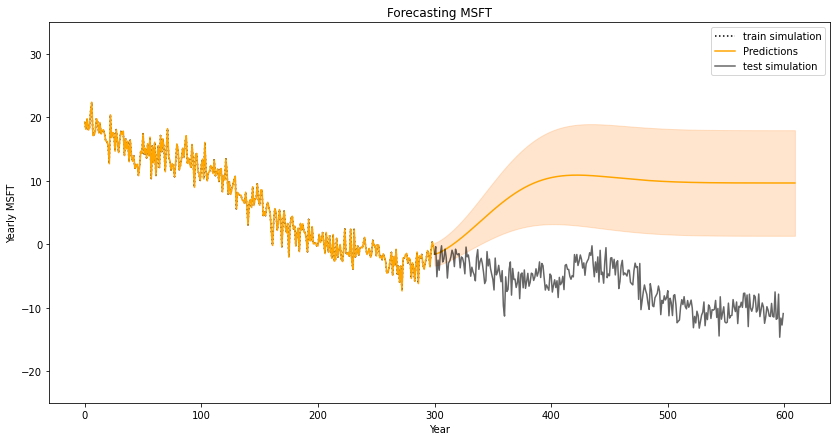

In [58]:
fig = plt.figure(figsize=(14,7))
plt.plot(X_train, y_train, color="black", linestyle="dotted", label="train simulation")
plt.plot(X_test, mean_y_pred, color="orange", label="Predictions")
plt.plot(xdatatest, y_test, color="black", alpha=0.6, label="test simulation")
plt.fill_between(
    X_test.ravel(),
    mean_y_pred - std_y_pred,
    mean_y_pred + std_y_pred,
    color="tab:orange",
    alpha=0.2,
)
plt.legend()

plt.xlabel("Year")

plt.ylabel("Yearly MSFT")
_ = plt.title(
    "Forecasting MSFT"
)

plt.ylim([-25, 35])

In [59]:
print("Long Term Cov. RBF, outputscale:", model.covar_module.kernels[0].outputscale)
print("Long Term Cov. RBF, lengthscale:", model.covar_module.kernels[0].base_kernel.lengthscale, "\n")

print("Seasonal Cov. RBF, outputscale:", model.covar_module.kernels[1].kernels[0].outputscale)
print("Seasonal Cov. RBF, lengthscale:", model.covar_module.kernels[1].kernels[0].base_kernel.lengthscale)
print("Seasonal Cov. PeriodicKernel, lengthscale:", model.covar_module.kernels[1].kernels[1].lengthscale)
print("Seasonal Cov. PeriodicKernel, period:", model.covar_module.kernels[1].kernels[1].period_length, "\n")

print("Irregularities, outputscale:", model.covar_module.kernels[2].outputscale)
print("Irregularities, lengthscale:", model.covar_module.kernels[2].base_kernel.lengthscale, "\n")

print("Extra Noise, outputscale:", model.covar_module.kernels[3].outputscale)
print("Extra Noise, lengthscale:", model.covar_module.kernels[3].base_kernel.lengthscale, "\n")

print("Likelihood noise:", model.likelihood.noise)


Long Term Cov. RBF, outputscale: tensor(65.8135, grad_fn=<SoftplusBackward0>)
Long Term Cov. RBF, lengthscale: tensor([[65.9557]], grad_fn=<SoftplusBackward0>) 



AttributeError: 'ScaleKernel' object has no attribute 'kernels'